In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from portfoliolab.utils import RiskMetrics
from portfoliolab.estimators import RiskEstimators, ReturnsEstimators

In [3]:
from pyfinlab import data_api as api
from pyfinlab import risk_models as rm
from pyfinlab import cov_matrix_test as test

Choose start and end dates

In [4]:
start_date = (datetime.today() - timedelta(days=365*10)).strftime('%Y-%m-%d')
end_date = (datetime.today() - timedelta(days=0)).strftime('%Y-%m-%d')

Download price data and compute returns

In [5]:
tickers = list(pd.read_csv('../data/classification_schema.csv').TICKER)
prices = api.price_history(tickers, start_date, end_date, api_source='yfinance')

[*********************100%***********************]  18 of 18 completed


Weights for equally-weighted portfolio

In [6]:
numstocks = prices.shape[1]
weights = np.repeat(1/numstocks, numstocks) # equal-weighted portfolio
if weights.sum()!=1.: raise ValueError('Your weights do not equal 100%') 
else: print('Total Weightings: {}%'.format(weights.sum()*100))

Total Weightings: 100.0%


## Portfolio Volatility Computed Using Each Risk Model

In [7]:
kde_bwidth = 0.01
basic_shrinkage = 0.1
covs = test.covariance_loop(prices, kde_bwidth, basic_shrinkage)
vols = test.volatility_loop(covs, weights)
vols

The average portfolio volatility using all price data as one sample: 0.081536


constant_residual_spectral_denoised       0.104811
hierarchical_filtered_complete            0.103572
exp_cov                                   0.099810
targeted_shrinkage_denoised               0.097195
empirical_covariance                      0.096995
sample_covariance                         0.096971
sample_cov                                0.096971
ledoit_wolf_single_factor                 0.096964
shrinked_covariance_oas                   0.096959
oracle_approximating                      0.096900
ledoit_wolf_constant_correlation          0.096731
ledoit_wolf_constant_variance             0.096463
shrinked_covariance_lw                    0.096436
constant_residual_eigenvalues_denoised    0.094080
shrinked_covariance_basic                 0.092614
hierarchical_filtered_avg                 0.079773
semicovariance                            0.078630
exponential_covariance                    0.071035
minimum_covariance_determinant            0.058006
targeted_shrinkage_detoned     

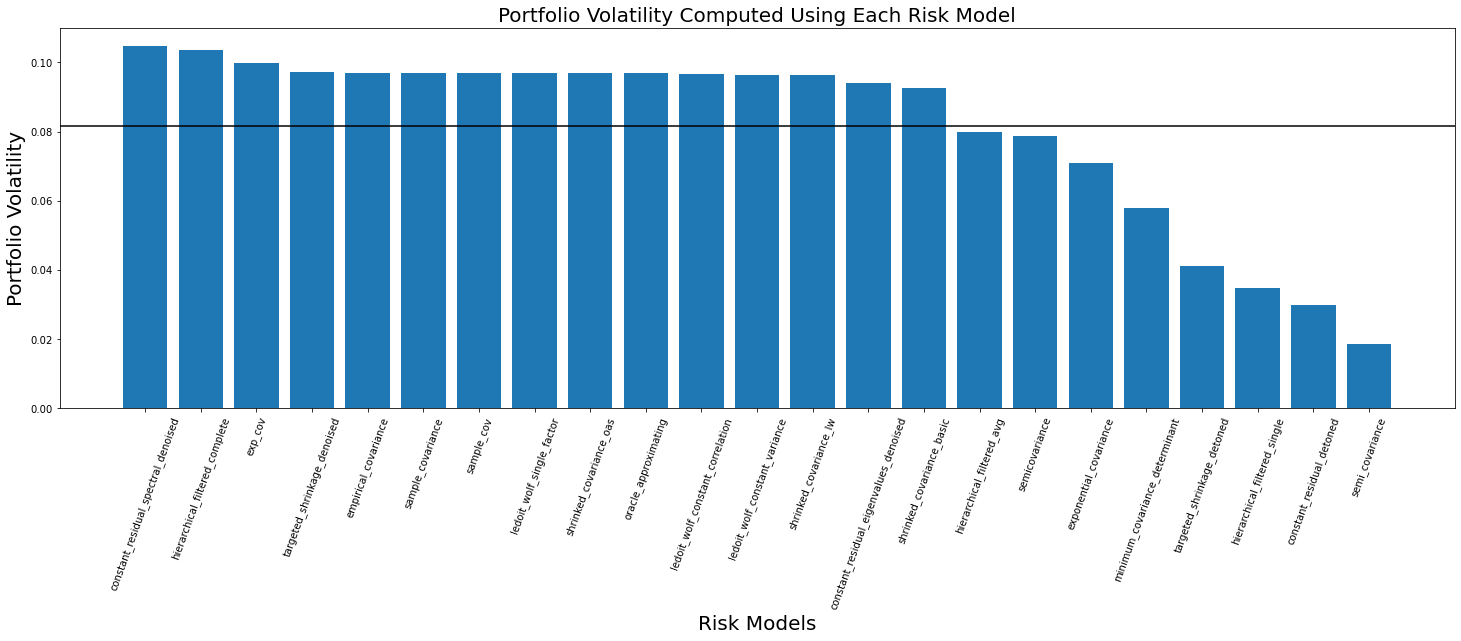

In [8]:
y_pos = np.arange(len(vols.index))
plt.figure(figsize=(25,7))
plt.bar(list(vols.index), vols.values)
plt.axhline(vols.mean(), color='black')
plt.xticks(y_pos, rotation=70, size=10)
plt.xlabel('Risk Models', size=20)
plt.ylabel('Portfolio Volatility', size=20)
plt.title('Portfolio Volatility Computed Using Each Risk Model', size=20)
plt.show()

## Out-of-Sample Test

The following code splits time series daily price data into sub-samples. Each risk model's covariance matrix of each
sub-sample is compared to the empirical covariance matrix of the next sequential sub-sample. The forecast error is measured 
by the Sum of Squared Errors (SSE) and averaged together for each risk model. The risk model with the lowest average
SSE is hypothetically the best risk model because it apparently had the lowest forecast error. 

In [9]:
subsample_size = 125 # days
num_of_samples = int(prices.shape[0] / subsample_size) # how many times to split sample

In [10]:
split_sample = test.split_sample(prices, num_of_samples, 'empirical_covariance') 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 99.11it/s]

Sub-sample size: 129 days
Number of samples: 18


In [11]:
sum_squared_errors = test.compute_sse(split_sample)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:11<00:00,  1.51it/s]


In [12]:
sse_averages = test.sse_average(sum_squared_errors)
sse_averages

Risk model with the lowest mean sum of squared error: minimum_covariance_determinant


minimum_covariance_determinant            5.063295
semicovariance                            6.036446
semi_covariance                           6.181266
exponential_covariance                    6.985373
shrinked_covariance_basic                 8.028584
shrinked_covariance_lw                    8.143498
ledoit_wolf_constant_variance             8.144874
shrinked_covariance_oas                   8.248555
oracle_approximating                      8.249733
exp_cov                                   8.255589
ledoit_wolf_single_factor                 8.305062
hierarchical_filtered_avg                 8.306311
hierarchical_filtered_single              8.306311
targeted_shrinkage_detoned                8.306311
constant_residual_detoned                 8.306311
targeted_shrinkage_denoised               8.306311
constant_residual_spectral_denoised       8.306311
constant_residual_eigenvalues_denoised    8.306311
empirical_covariance                      8.306311
hierarchical_filtered_complete 

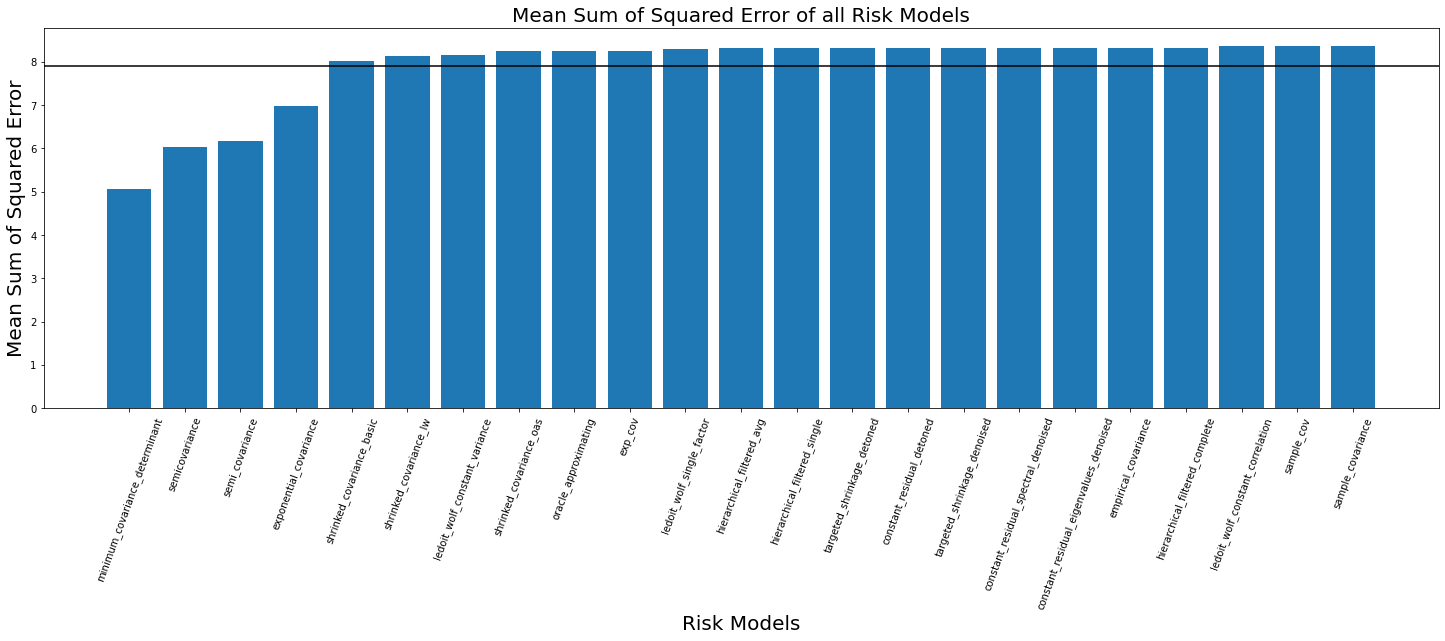

In [13]:
y_pos = np.arange(len(sse_averages.index))
plt.figure(figsize=(25,7))
plt.bar(list(sse_averages.index), sse_averages.squeeze().values)
plt.axhline(sse_averages.squeeze().mean(), color='black')
plt.xticks(y_pos, rotation=70, size=10)
plt.xlabel('Risk Models', size=20)
plt.ylabel('Mean Sum of Squared Error', size=20)
plt.title('Mean Sum of Squared Error of all Risk Models', size=20)
plt.show()

In [14]:
win_count = test.win_count(sum_squared_errors)

The risk model with the most months with the lowest mean SSE: sample_covariance
                                        Win Count
sample_covariance                               5
exponential_covariance                          4
minimum_covariance_determinant                  4
shrinked_covariance_basic                       2
ledoit_wolf_constant_variance                   1
hierarchical_filtered_complete                  0
ledoit_wolf_constant_correlation                0
ledoit_wolf_single_factor                       0
exp_cov                                         0
semicovariance                                  0
sample_cov                                      0
hierarchical_filtered_avg                       0
hierarchical_filtered_single                    0
targeted_shrinkage_detoned                      0
constant_residual_detoned                       0
targeted_shrinkage_denoised                     0
constant_residual_spectral_denoised             0
constant_residual_ei

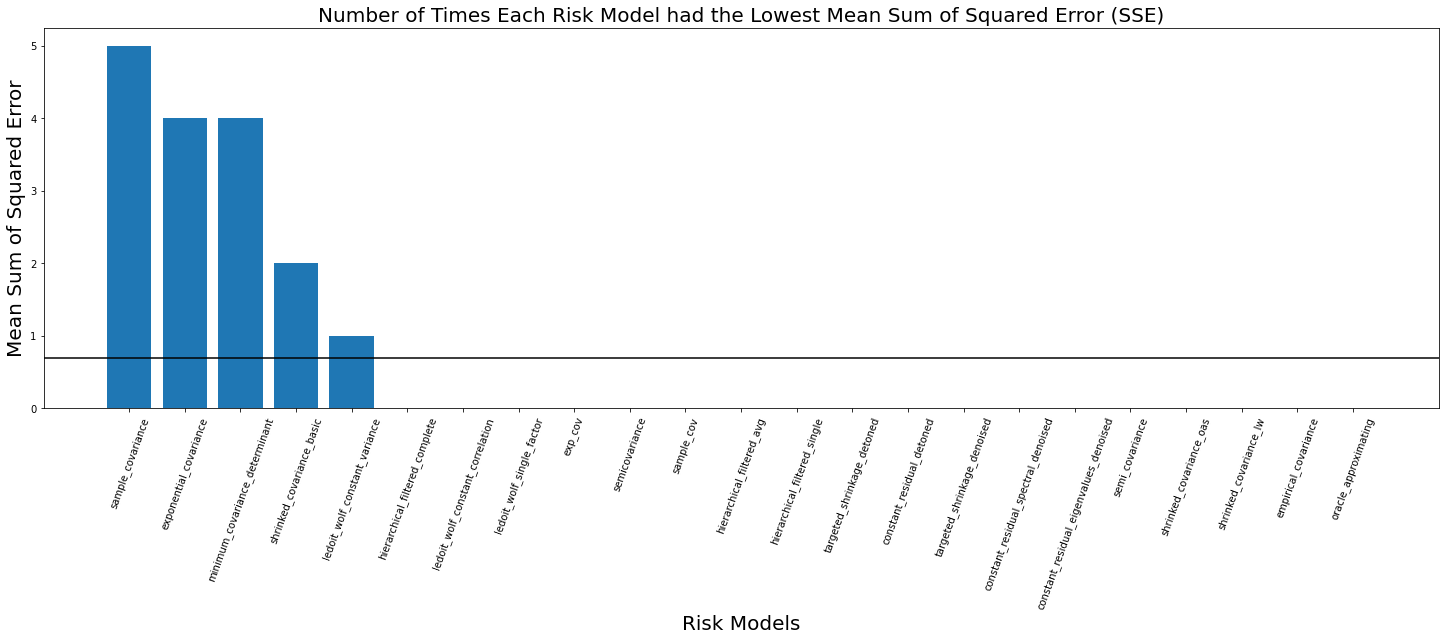

In [15]:
y_pos = np.arange(len(win_count.index))
plt.figure(figsize=(25,7))
plt.bar(list(win_count.index), win_count.squeeze().values)
plt.axhline(win_count.squeeze().mean(), color='black')
plt.xticks(y_pos, rotation=70, size=10)
plt.xlabel('Risk Models', size=20)
plt.ylabel('Mean Sum of Squared Error', size=20)
plt.title('Number of Times Each Risk Model had the Lowest Mean Sum of Squared Error (SSE)', size=20)
plt.show()